## Table of Content: 
* [1. Factors affecting hourly sales](#section1)

    * [1) Initial data processing](#section1_1)
    * [2) Check and deal with missing values](#section1_2)
    * [3) Calculate hourly sales and average distance](#section1_3)
    * [4) Exploratory data analysis (EDA)](#section1_4)

* [2. Prediction of hourly sales](#section2)

    * [1) Feature engineering](#section2_1)
    * [2) Coefficient](#section2_2)
    * [3) Correlation matrix](#section2_3)
    * [4) Polynomial regression model (degree = 3)](#section2_4)
    * [5) Assumptions](#section2_5)

* [3. Discussion about other models](#section3)

    * [1) Linear regression model](#section3_1)
    * [2) Polynomial regression model (degree = 3, one feature)](#section3_2)
    * [3) Polynomial regression model (degree = 2)](#section3_3)

# Background
This report intends to assist a group of coffee-loving University of Sydney alumni to analyse the feasibility of establishing a coffee business on University of Sydney campus. Based on the sales and other relevant data collected from the pop-up store called “Café Insomnia” which is set temporarily for testing their business plan, exploratory data analysis (EDA) is performed to identify the factors affecting Café Insomnia’s hourly sales. Then, a polynomial model was constructed using these factors to predict and quantify their effects on hourly sales.

Individual transaction records of the pop-up store are collected from 2019 July 22 to 2019 December 22. In addition to purchase related information, each customer was asked to select where on campus she/he was studying and whether it is raining. 

## 1. Factors affecting hourly sales <a class="anchor" id="section1"></a >

## 1) Initial data processing <a class="anchor" id="section1_1"></a >

In [ ]:
# Packages
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Connect to the database
conn = sqlite3.connect("cafe_insomnia.sqlite")
c = conn.cursor()

# List the tables
c.execute("SELECT name FROM sqlite_master WHERE type='table'")
c.fetchall()

[('study_area',), ('drink',), ('ci_transaction',)]

In [ ]:
# Import the data
query = '''SELECT *
           FROM ci_transaction as t
           LEFT JOIN drink as d
           ON t.drink_id = d.id
           LEFT JOIN study_area as a
           ON t.study_area_id = a.id'''
df_transaction = pd.read_sql(query,conn)
df_transaction = df_transaction.drop(columns=['drink_id', 'study_area_id', 'id'])
df_transaction = df_transaction.rename(columns = {'name':'drink_name','name':'study_area'})
df_transaction.columns = ['date', 'days_after_open', 'day_of_week', 'hours_after_open',
       'quantity', 'raining', 'drink_name', 'unit_price', 'study_area','dist_to_cafe']

# Display the data
df_transaction.head()

,date,days_after_open,day_of_week,hours_after_open,quantity,raining,drink_name,unit_price,study_area,dist_to_cafe
0,2019-07-22,0,Mon,0,1,No,Flat White (L),4.9,Abercrombie (H70),700.0
1,2019-07-22,0,Mon,0,1,No,Flat White (L),4.9,Law Library (F10),84.0
2,2019-07-22,0,Mon,0,1,No,Macchiato,3.8,Carslaw (F07),150.0
3,2019-07-22,0,Mon,0,1,No,Macchiato,3.8,Peter Nicol Russell (PNR),950.0
4,2019-07-22,0,Mon,0,1,No,Flat White (L),4.9,Carslaw (F07),150.0


In [ ]:
df_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27714 entries, 0 to 27713
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              27714 non-null  object 
 1   days_after_open   27714 non-null  int64  
 2   day_of_week       27714 non-null  object 
 3   hours_after_open  27714 non-null  int64  
 4   quantity          27714 non-null  int64  
 5   raining           27714 non-null  object 
 6   drink_name        27714 non-null  object 
 7   unit_price        27714 non-null  float64
 8   study_area        27171 non-null  object 
 9   dist_to_cafe      27171 non-null  float64
dtypes: float64(2), int64(3), object(5)
memory usage: 2.1+ MB


## 2) Check and deal with missing values <a class="anchor" id="section1_2"></a >

### a. Study Area and Dist to Cafe 

In [ ]:
mode_area = df_transaction[['study_area','dist_to_cafe']].mode()
mode_area

,study_area,dist_to_cafe
0,Fisher Library (F03),70.0


In [ ]:
# replace with mode
df_transaction['study_area'].fillna('Fisher Library (F03)',inplace=True)
#df_transaction[df_transaction['study_area'] == 'Fisher Library (F03)']['dist_to_cafe']
df_transaction['dist_to_cafe'].fillna(70,inplace=True)

### b. Raining 

In [ ]:
# drop missing values to identify the pattern
rain_not_missing = df_transaction.query("raining != 'NA'").groupby(['date','hours_after_open'], as_index=False)

# present each specific hours to get how many categories of raining record
rain_not_missing = rain_not_missing.nunique()
rain_not_missing # after dropping missing values there are still 924(154*6) hours data

,date,hours_after_open,days_after_open,day_of_week,quantity,raining,drink_name,unit_price,study_area,dist_to_cafe
0,2019-07-22,0,1,1,1,1,6,3,6,6
1,2019-07-22,1,1,1,3,1,8,5,6,6
2,2019-07-22,2,1,1,2,1,5,4,2,2
3,2019-07-22,3,1,1,2,1,7,5,5,5
4,2019-07-22,4,1,1,2,1,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...
919,2019-12-22,1,1,1,4,1,16,9,7,7
920,2019-12-22,2,1,1,4,1,17,10,7,7
921,2019-12-22,3,1,1,4,1,17,10,3,3
922,2019-12-22,4,1,1,4,1,16,10,7,7


In [ ]:
# check if there is only one raining condition for every hour
rain_not_missing.value_counts('raining')

raining
1    924
dtype: int64

In [ ]:
# fill in missing values with raining condition in the same hour
for i in df_transaction[df_transaction['raining'] == 'NA'].index:
    if df_transaction.loc[i+1, 'raining'] != 'NA' and df_transaction.loc[i, 'hours_after_open'] == df_transaction.loc[i+1, 'hours_after_open']:
        df_transaction.loc[i, 'raining'] = df_transaction.loc[i+1, 'raining']
    elif df_transaction.loc[i-1, 'raining'] != 'NA' and df_transaction.loc[i, 'hours_after_open'] == df_transaction.loc[i-1, 'hours_after_open']:
        df_transaction.loc[i, 'raining'] = df_transaction.loc[i-1, 'raining']

# check
df_transaction[df_transaction['raining'] == 'NA']

,date,days_after_open,day_of_week,hours_after_open,quantity,raining,drink_name,unit_price,study_area,dist_to_cafe


In [ ]:
df_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27714 entries, 0 to 27713
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              27714 non-null  object 
 1   days_after_open   27714 non-null  int64  
 2   day_of_week       27714 non-null  object 
 3   hours_after_open  27714 non-null  int64  
 4   quantity          27714 non-null  int64  
 5   raining           27714 non-null  object 
 6   drink_name        27714 non-null  object 
 7   unit_price        27714 non-null  float64
 8   study_area        27714 non-null  object 
 9   dist_to_cafe      27714 non-null  float64
dtypes: float64(2), int64(3), object(5)
memory usage: 2.1+ MB


## 3) Calculate hourly sales and average distance <a class="anchor" id="section1_3"></a >

In [ ]:
# calculate sales per transaction
df_transaction['sales'] = df_transaction['unit_price'] * df_transaction['quantity']

# create new dataframe containing hourly sales
df_transaction2 = df_transaction.groupby(['date', 'days_after_open', 'day_of_week', 'hours_after_open', 'raining'], as_index=False)['sales'].agg({'hourly_sales' : 'sum'})
distance = df_transaction.groupby(['days_after_open','hours_after_open'], as_index=False)['dist_to_cafe'].mean()
df_transaction2['dist_to_cafe'] = distance['dist_to_cafe']
df_transaction2

,date,days_after_open,day_of_week,hours_after_open,raining,hourly_sales,dist_to_cafe
0,2019-07-22,0,Mon,0,No,49.0,264.363636
1,2019-07-22,0,Mon,1,No,83.6,246.769231
2,2019-07-22,0,Mon,2,Yes,37.3,77.000000
3,2019-07-22,0,Mon,3,No,53.9,426.444444
4,2019-07-22,0,Mon,4,Yes,16.1,101.333333
...,...,...,...,...,...,...,...
919,2019-12-22,153,Sun,1,No,373.4,268.343750
920,2019-12-22,153,Sun,2,No,340.8,281.709677
921,2019-12-22,153,Sun,3,Yes,266.0,81.440000
922,2019-12-22,153,Sun,4,No,328.9,308.966667


## 4) Exploratory data analysis (EDA) <a class="anchor" id="section1_4"></a >

### a. Days After Open and Hourly Sales

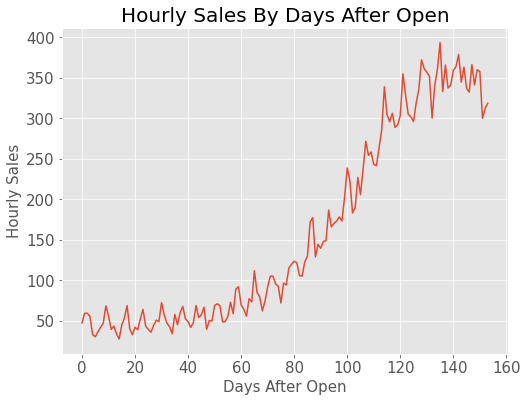

In [ ]:
# line plot
fig = plt.subplots(figsize=(8,6))
hourly_sales1 = df_transaction2.groupby(['days_after_open'])['hourly_sales'].mean()
plt.plot(hourly_sales1)
plt.style.use('ggplot')
plt.xlabel('Days After Open', size = 15)
plt.ylabel('Hourly Sales', size = 15)
plt.title('Hourly Sales By Days After Open', size = 20)

# https://stackoverflow.com/questions/37427362/plt-show-shows-full-graph-but-savefig-is-cropping-the-image/37428142
plt.savefig('Figure 1', bbox_inches='tight')
plt.show()


In [ ]:
# pearsonr hypothesis test
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html
from scipy.stats import pearsonr
r, p_value = pearsonr(df_transaction2['hourly_sales'], df_transaction2['days_after_open'])
r, p_value # p<0.05

(0.9106884480168655, 0.0)

### b. Day of Week and Hourly Sales

In [ ]:
# Create a new column 'day_of_week_num'
# https://blog.csdn.net/ztf312/article/details/88322222
import time
week = [1,2,3,4,5,6,7]
df_transaction2['day_of_week_num'] = pd.Series(week[time.strptime(x, '%a').tm_wday] for x in df_transaction2['day_of_week'])
df_transaction2.head()

,date,days_after_open,day_of_week,hours_after_open,raining,hourly_sales,dist_to_cafe,day_of_week_num
0,2019-07-22,0,Mon,0,No,49.0,264.363636,1
1,2019-07-22,0,Mon,1,No,83.6,246.769231,1
2,2019-07-22,0,Mon,2,Yes,37.3,77.000000,1
3,2019-07-22,0,Mon,3,No,53.9,426.444444,1
4,2019-07-22,0,Mon,4,Yes,16.1,101.333333,1


   day_of_week_num  hourly_sales
0                1    149.309848
1                2    158.787879
2                3    181.436364
3                4    169.000000
4                5    156.992424


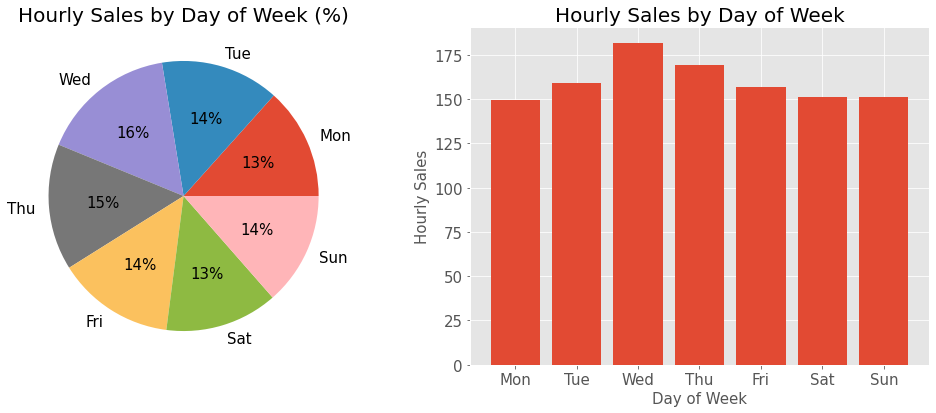

In [ ]:
# https://stackoverflow.com/questions/56298327/how-to-scale-a-pie-chart-and-bar-chart-to-both-display

# Group "hourly_sales" by “day_of_week”
avg_hourly_sales3 = df_transaction2.groupby('day_of_week_num', as_index=False).agg({'hourly_sales' : 'mean'})
print(avg_hourly_sales3.head())

# Set plots
#https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
#https://cloud.tencent.com/developer/article/1525349
plt.subplots(figsize = (14,6))
plt.rcParams['font.size'] = 15

# Create pieplot
plt.subplot(121)
pie = plt.pie(avg_hourly_sales3['hourly_sales'],labels = df_transaction2['day_of_week'].unique(), autopct = '%.0f%%')
plt.title('Hourly Sales by Day of Week (%)', size = 20)

# Create barplot
plt.subplot(122)
plt.bar(df_transaction2['day_of_week'].unique(), height = avg_hourly_sales3['hourly_sales'])

plt.title('Hourly Sales by Day of Week', size = 20)
plt.xlabel('Day of Week', size = 15)
plt.ylabel('Hourly Sales', size = 15)

# https://stackoverflow.com/questions/9603230/how-to-use-matplotlib-tight-layout-with-figure
plt.tight_layout()

plt.savefig('Figure 2&3')
plt.show()

### c. Hours After Open and Hourly Sales

   hours_after_open  hourly_sales
0                 0    167.755195
1                 1    175.916234
2                 2    169.150000
3                 3    158.508442
4                 4    148.833766
5                 5    137.917532


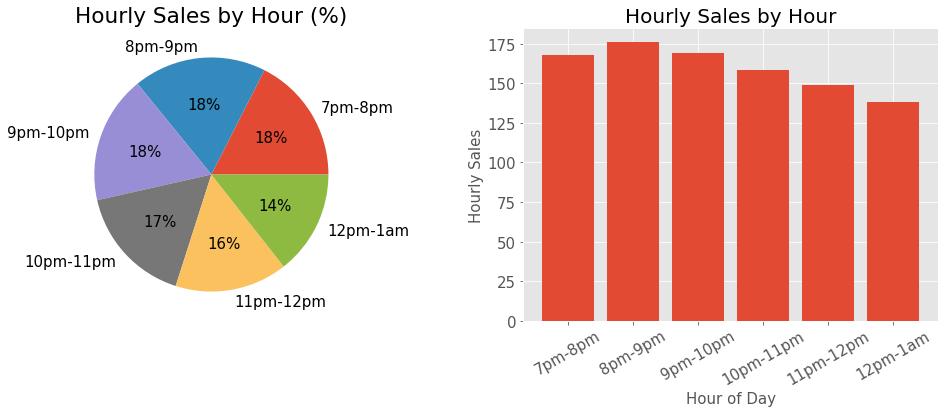

In [ ]:
# change int to specific time period
hour_of_day_name = []
for i in range(5):
    x = str(i + 7) + 'pm-' + str(i + 8) + 'pm'
    hour_of_day_name.append(x)
hour_of_day_name.append('12pm-1am')

# Set plots
plt.subplots(figsize = (14,6))

# Create pieplot
plt.subplot(121)
avg_hourly_sales4 = df_transaction2.groupby('hours_after_open', as_index=False).agg({'hourly_sales' : 'mean'})
print(avg_hourly_sales4)
pie = plt.pie(avg_hourly_sales4['hourly_sales'],labels = hour_of_day_name, autopct = '%.0f%%')
plt.title('Hourly Sales by Hour (%)')

# Create barplot
plt.subplot(122)
plt.bar(hour_of_day_name, height = avg_hourly_sales4['hourly_sales'])

plt.xlabel('Hour of Day', size = 15)
plt.ylabel('Hourly Sales', size = 15)
plt.xticks(rotation = 30)
plt.title('Hourly Sales by Hour', size = 20)

plt.tight_layout()
plt.savefig('Figure 4&5')
plt.show()

### d. Raining and Hourly Sales

In [ ]:
research_raining = df_transaction2[['date','hours_after_open','raining','hourly_sales']]
raining_grp = research_raining.groupby(['date' ,'hours_after_open','raining']).sum('hourly_sales')

In [ ]:
rain_yes = raining_grp.query("raining == 'Yes'")['hourly_sales']
rain_no = raining_grp.query("raining == 'No'")['hourly_sales']

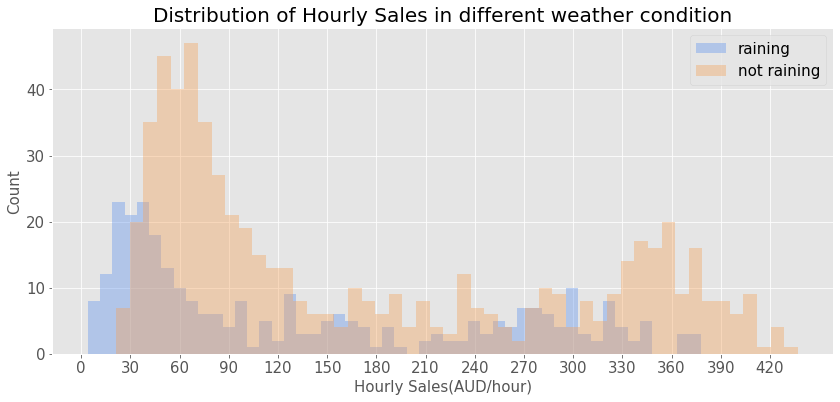

In [ ]:
# set histogram size
plt.figure(figsize=[14,6])

# set the no. of bins, transparency, color, label of histogram
plt.hist(rain_yes,bins= 50, alpha = 0.4, color = "cornflowerblue",label = 'raining')
plt.hist (rain_no, bins = 50, alpha = 0.4, color = "sandybrown", label = 'not raining')

# set labels and title of the histogram
plt.ylabel("Count", fontsize = '15')
plt.xlabel("Hourly Sales(AUD/hour)", fontsize = '15')
plt.title("Distribution of Hourly Sales in different weather condition", fontsize = '20')

# set the x-axis ticks for the convenience of comparison of distribution of hourly sales between rainy and no rain condition
plt.xticks(np.arange(0,450,30))

# show labels
plt.legend()
plt.savefig('Figure 6')
# show histogram
plt.show()


### e. Distance and Hourly Sales

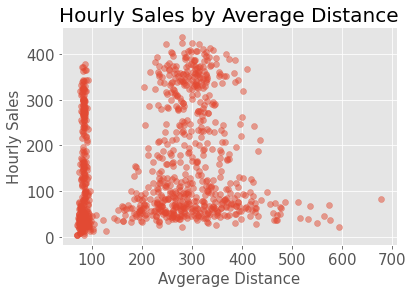

In [ ]:
# scatter plot
distance = df_transaction2['dist_to_cafe']
hourly_sales = df_transaction2['hourly_sales']
plt.scatter(distance,hourly_sales, alpha = 0.5)

plt.xlabel('Avgerage Distance', size = 15)
plt.ylabel('Hourly Sales', size = 15)
plt.title('Hourly Sales by Average Distance', size = 20)

plt.savefig('Figure 7', bbox_inches = 'tight')
plt.show()

### f. Raining, Distance to Cafe and Sales

In [ ]:
#Total hourly sales of different distances to cafe on rainy or not rainy days
df_transaction.groupby(['raining','dist_to_cafe']).sum()['sales'].reset_index()

,raining,dist_to_cafe,sales
0,No,70.0,22743.4
1,No,84.0,20843.8
2,No,150.0,21102.1
3,No,350.0,10550.7
4,No,400.0,10247.6
5,No,700.0,10975.9
6,No,950.0,10945.9
7,Yes,70.0,20361.1
8,Yes,84.0,15684.1
9,Yes,150.0,4089.9


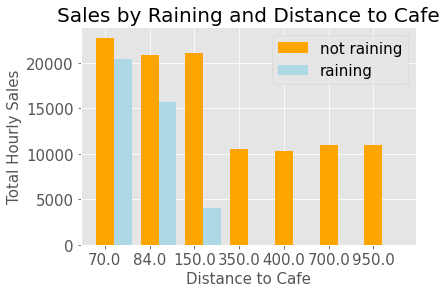

In [ ]:
# bar plot
xpos = [0, 1, 2, 3, 4, 5, 6]
height1 = [22743.4, 20843.8, 21102.1, 10550.7, 10247.6, 10975.9, 10945.9]
height2 = [20361.1, 15684.1, 4089.9, 0, 0, 0, 0]

w = 0.4 
adjusted_xpos = np.add(xpos, w)

plt.bar(xpos, height1, width = w, color = 'orange', label = 'not raining')
plt.bar(adjusted_xpos, height2, width = w, color = 'lightblue', label = 'raining')

labels = ['70.0', '84.0', '150.0', '350.0', '400.0', '700.0', '950.0']
plt.xticks(xpos, labels)

plt.xlabel('Distance to Cafe', size = 15)
plt.ylabel('Total Hourly Sales', size = 15)
plt.title('Sales by Raining and Distance to Cafe', size = 20)
plt.legend()

plt.savefig('Figure 8', bbox_inches = 'tight')

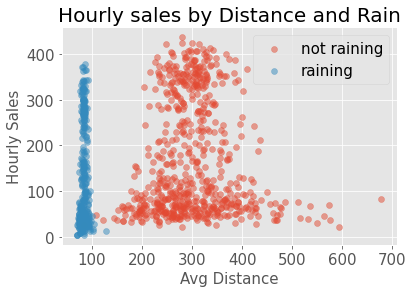

In [ ]:
# avg distance&rain and hourly sales
df_not_rain = df_transaction2[df_transaction2['raining'] == 'No'][['hourly_sales', 'dist_to_cafe']]
df_rain = df_transaction2[df_transaction2['raining'] == 'Yes'][['hourly_sales', 'dist_to_cafe']]

plt.scatter(df_not_rain['dist_to_cafe'], df_not_rain['hourly_sales'], alpha = 0.5, label = 'not raining')
plt.scatter(df_rain['dist_to_cafe'], df_rain['hourly_sales'], alpha = 0.5, label = 'raining')

plt.legend()
plt.xlabel('Avg Distance', size = 15)
plt.ylabel('Hourly Sales', size = 15)
plt.title('Hourly sales by Distance and Rain', size = 20)
plt.savefig('Figure 9', bbox_inches = 'tight')
plt.show()

### g) Raining and Quantity

In [ ]:
df_transaction.groupby(['raining','quantity']).sum()['sales'].reset_index()

,raining,quantity,sales
0,No,1,67927.6
1,No,2,25206.6
2,No,3,7017.6
3,No,4,7257.6
4,Yes,1,25666.3
5,Yes,2,9167.8
6,Yes,3,3017.4
7,Yes,4,2283.6


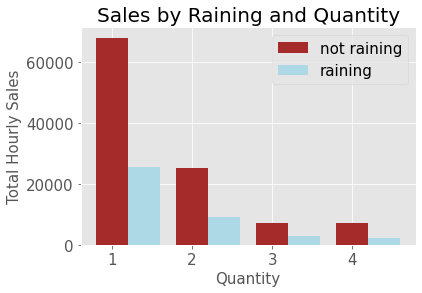

In [ ]:
xpos = [0, 1, 2, 3]
height1 = [67927.6,25206.6,7017.6,7257.6]
height2 = [25666.3,9167.8,3017.4,2283.6]

w = 0.4 
adjusted_xpos = np.add(xpos, w)

plt.bar(xpos, height1, width = w, color = 'brown', label = 'not raining')
plt.bar(adjusted_xpos, height2, width = w, color = 'lightblue', label = 'raining')

labels = ['1', '2', '3', '4']
plt.xticks(xpos, labels)

plt.xlabel('Quantity', size = 15)
plt.ylabel('Total Hourly Sales', size = 15)
plt.title('Sales by Raining and Quantity', size = 20)
plt.legend()

plt.savefig('Figure 10', bbox_inches = 'tight')

## 2. Prediction of hourly sales <a class="anchor" id="section2"></a >

## 1) Feature engineering <a class="anchor" id="section2_1"></a >

In [ ]:
# create dummy variables for raining
dummy_variables = pd.get_dummies(df_transaction2['raining'], drop_first = True)
df_transaction2 = pd.concat([df_transaction2, dummy_variables], axis = 1)

# create dummy variables for hours_after_open
# exclude hours_after_open_5
def dummy1(df_transaction2): 
    df_transaction2['hours_after_open_0']=(df_transaction2['hours_after_open']==0).astype(int)
    df_transaction2['hours_after_open_1']=(df_transaction2['hours_after_open']==1).astype(int)
    df_transaction2['hours_after_open_2']=(df_transaction2['hours_after_open']==2).astype(int)
    df_transaction2['hours_after_open_3']=(df_transaction2['hours_after_open']==3).astype(int)
    df_transaction2['hours_after_open_4']=(df_transaction2['hours_after_open']==4).astype(int)

    return df_transaction2

# create dummy variables for day_of_week
# exclude day_of_week_7
def dummy2(df_transaction2): 
    df_transaction2['day_of_week_1']=(df_transaction2['day_of_week_num']==1).astype(int)
    df_transaction2['day_of_week_2']=(df_transaction2['day_of_week_num']==2).astype(int)
    df_transaction2['day_of_week_3']=(df_transaction2['day_of_week_num']==3).astype(int)
    df_transaction2['day_of_week_4']=(df_transaction2['day_of_week_num']==4).astype(int)
    df_transaction2['day_of_week_5']=(df_transaction2['day_of_week_num']==5).astype(int)  
    df_transaction2['day_of_week_6']=(df_transaction2['day_of_week_num']==6).astype(int)

    return df_transaction2

# rename certain column
df_transaction2 = df_transaction2.rename(columns={'Yes':'raining_yes'})

# add dummies to the dataframe
df_transaction2 = dummy1(df_transaction2)
df_transaction2 = dummy2(df_transaction2)

# drop columns which are not useful in modeling
df_transaction2.drop('date', inplace = True, axis = 1)
df_transaction2.drop('hours_after_open', inplace = True, axis = 1)
df_transaction2.drop('day_of_week', inplace = True, axis = 1)
df_transaction2.drop('raining', inplace = True, axis = 1)
df_transaction2.drop('dist_to_cafe', inplace = True, axis = 1)
df_transaction2.drop('day_of_week_num', inplace = True, axis = 1)
df_transaction2

,days_after_open,hourly_sales,raining_yes,hours_after_open_0,hours_after_open_1,hours_after_open_2,hours_after_open_3,hours_after_open_4,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,0,49.0,0,1,0,0,0,0,1,0,0,0,0,0
1,0,83.6,0,0,1,0,0,0,1,0,0,0,0,0
2,0,37.3,1,0,0,1,0,0,1,0,0,0,0,0
3,0,53.9,0,0,0,0,1,0,1,0,0,0,0,0
4,0,16.1,1,0,0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,153,373.4,0,0,1,0,0,0,0,0,0,0,0,0
920,153,340.8,0,0,0,1,0,0,0,0,0,0,0,0
921,153,266.0,1,0,0,0,1,0,0,0,0,0,0,0
922,153,328.9,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
# create polynomial terms
df_transaction2['days_after_open^2'] = df_transaction2['days_after_open'] ** 2
df_transaction2['days_after_open^3'] = df_transaction2['days_after_open'] ** 3

## 2) Coefficient <a class="anchor" id="section2_2"></a >

In [ ]:
# observe coefficient with hourly sales
matrix = df_transaction2[df_transaction2.columns]
corr = matrix.corr()
corr['hourly_sales'].abs().sort_values(ascending = False)

hourly_sales          1.000000
days_after_open^2     0.945205
days_after_open^3     0.924779
days_after_open       0.910688
raining_yes           0.144048
day_of_week_3         0.072685
hours_after_open_1    0.059420
hours_after_open_4    0.039695
hours_after_open_2    0.034657
day_of_week_1         0.034646
day_of_week_4         0.031136
hours_after_open_0    0.029553
day_of_week_6         0.029372
day_of_week_5         0.008980
hours_after_open_3    0.004288
day_of_week_2         0.002981
Name: hourly_sales, dtype: float64

## 3) Correlation matrix <a class="anchor" id="section2_3"></a >

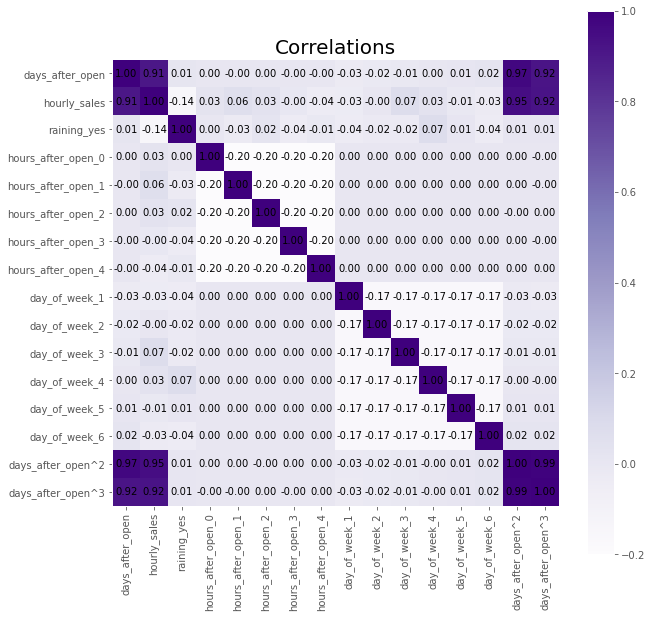

In [ ]:
# Create heatmap
plt.subplots(figsize = (10,10))
n_var = len(corr)

# hide grid lines
#https://stackoverflow.com/questions/55367772/removing-grid-lines-in-subplot
plt.rcParams["axes.grid"] = False

plt.imshow(corr, cmap = 'Purples')
plt.xticks(range(n_var), corr.columns)
plt.yticks(range(n_var), corr.columns)
plt.xticks(rotation = 90)

for i in range(n_var):
    for j in range(n_var):
        plt.text(i,j,'{:.2f}'.format(corr.iloc[i,j]), ha = 'center', va = 'center', color = 'k', fontsize = 10)
plt.colorbar()
plt.title('Correlations', fontsize = 20)
plt.savefig('Figure 11', bbox_inches = 'tight')
plt.show() 

## 4) Polynomial regression model (degree = 3) <a class="anchor" id="section2_4"></a >

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

In [ ]:
# get column names
df_transaction2.columns

Index(['days_after_open', 'hourly_sales', 'raining_yes', 'hours_after_open_0',
       'hours_after_open_1', 'hours_after_open_2', 'hours_after_open_3',
       'hours_after_open_4', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
       'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'days_after_open^2',
       'days_after_open^3'],
      dtype='object')

In [ ]:
predictors = ['days_after_open', 'days_after_open^2', 'days_after_open^3', 'raining_yes', 'hours_after_open_0',
       'hours_after_open_1', 'hours_after_open_2', 'hours_after_open_3',
       'hours_after_open_4', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
       'day_of_week_4', 'day_of_week_5', 'day_of_week_6']

X = df_transaction2[predictors].to_numpy().reshape(-1,len(predictors))
y = df_transaction2['hourly_sales'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

linear_reg = LinearRegression(fit_intercept = True)
linear_reg.fit(X_train, y_train)
y_pred_poly = linear_reg.predict(X_test.reshape(-1,len(predictors)))

# intercept and coefficient
print('intercept: {:.4f}'.format(linear_reg.intercept_))
for i in range(len(predictors)):
    print(predictors[i]+': {:.4f}'.format(linear_reg.coef_[i]))

intercept: 62.6987
days_after_open: -3.6839
days_after_open^2: 0.0743
days_after_open^3: -0.0002
raining_yes: -38.5348
hours_after_open_0: 26.8359
hours_after_open_1: 33.8555
hours_after_open_2: 26.9768
hours_after_open_3: 16.8915
hours_after_open_4: 4.4477
day_of_week_1: 4.4372
day_of_week_2: 14.6793
day_of_week_3: 35.0043
day_of_week_4: 24.8866
day_of_week_5: 8.2170
day_of_week_6: -2.5238


rmse: 26.159038508637767


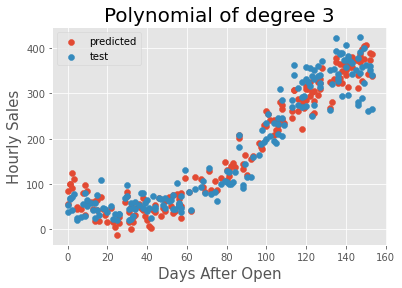

In [ ]:
# evaluation and plot
# test MSE
print('rmse:', MSE(y_test, y_pred_poly)**0.5)
plt.rcParams["axes.grid"] = True
plt.scatter(X_test[:,0], y_pred_poly, label = 'predicted')
plt.scatter(X_test[:,0], y_test, label = 'test')
plt.legend()
plt.xlabel('Days After Open', size = 15)
plt.ylabel('Hourly Sales', size = 15)
plt.title('Polynomial of degree 3', size =20)
plt.savefig('Figure 12', bbox_inches = 'tight')
plt.show()

## 5) Assumptions <a class="anchor" id="section2_5"></a >

### a. Residual Plot 

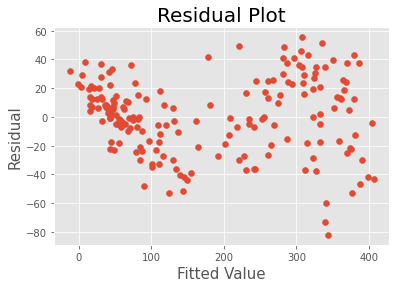

In [ ]:
# residual plot - polynomial regression
residuals_poly = y_test - y_pred_poly
plt.scatter(y_pred_poly, residuals_poly)
plt.xlabel('Fitted Value', size = 15)
plt.ylabel('Residual', size = 15)
plt.title('Residual Plot', size = 20)
plt.savefig('Figure 13', bbox_inches = 'tight')
plt.show()

### b. Squared Residual Plot 

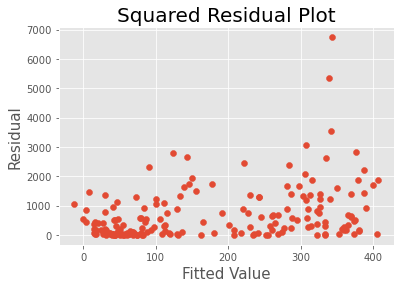

In [ ]:
# residual plot - polynomial regression
residuals_poly2 = (y_test - y_pred_poly)**2
plt.scatter(y_pred_poly, residuals_poly2)
plt.xlabel('Fitted Value', size = 15)
plt.ylabel('Residual', size = 15)
plt.title('Squared Residual Plot', size = 20)
plt.savefig('Figure 14', bbox_inches = 'tight')
plt.show()

### c. Q-Q Plot 

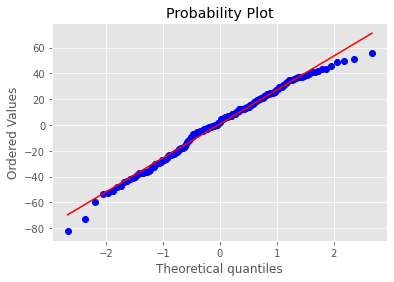

In [ ]:
# Q-Q plot - polynomial regression
# https://cloud.tencent.com/developer/article/1536551
from scipy.stats import probplot
probplot(residuals_poly, plot = plt)
plt.savefig('Figure 15', bbox_inches = 'tight')
plt.show()

## 3. Discussion about other models <a class="anchor" id="section3"></a >

## 1) Linear regression model <a class="anchor" id="section3_1"></a >

rmse: 42.25718817321991


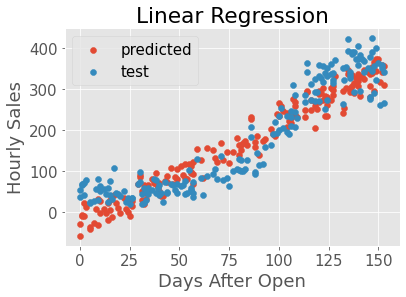

In [ ]:
# variable selection
predictors = ['days_after_open', 'raining_yes', 'hours_after_open_0',
       'hours_after_open_1', 'hours_after_open_2', 'hours_after_open_3',
       'hours_after_open_4', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
       'day_of_week_4', 'day_of_week_5', 'day_of_week_6']

# build model
X = df_transaction2[predictors].to_numpy().reshape(-1,len(predictors))
y = df_transaction2['hourly_sales'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

linear_reg = LinearRegression(fit_intercept = True)
linear_reg.fit(X_train, y_train)
y_pred = linear_reg.predict(X_test.reshape(-1,len(predictors)))

# test MSE
print('rmse:', MSE(y_test, y_pred)**0.5)

plt.scatter(X_test[:,0], y_pred, label = 'predicted')
plt.scatter(X_test[:,0], y_test, label = 'test')
plt.legend()
plt.xlabel('Days After Open')
plt.ylabel('Hourly Sales')
plt.title('Linear Regression')
plt.show() 
# poor prediction

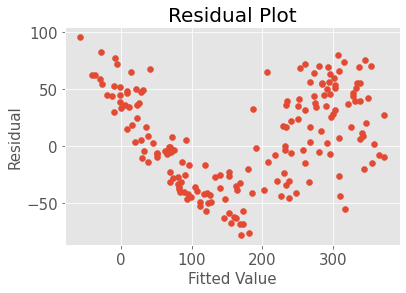

In [ ]:
# residual plot - linear regression
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel('Fitted Value', size = 15)
plt.ylabel('Residual', size = 15)
plt.title('Residual Plot', size = 20)
plt.show() # patterns

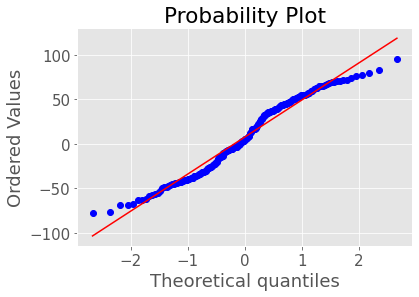

In [ ]:
# Q-Q plot - linear regression
probplot(residuals, plot = plt)
plt.show() # not normal

## 2) Polynomial regression model (degree = 3, one feature) <a class="anchor" id="section3_2"></a >

rmse: 36.183136929007375


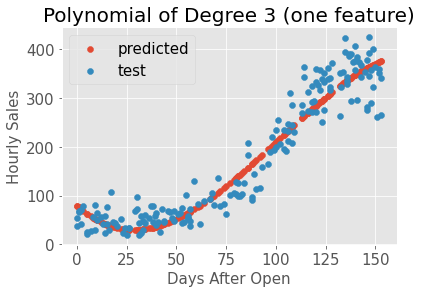

In [ ]:
# variable selection
predictors = ['days_after_open', 'days_after_open^2', 'days_after_open^3']

X = df_transaction2[predictors].to_numpy().reshape(-1,len(predictors))
y = df_transaction2['hourly_sales'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

linear_reg = LinearRegression(fit_intercept = True)
linear_reg.fit(X_train, y_train)
y_pred_poly1 = linear_reg.predict(X_test.reshape(-1,len(predictors)))

# test MSE
print('rmse:', MSE(y_test, y_pred_poly1)**0.5)

plt.scatter(X_test[:,0], y_pred_poly1, label = 'predicted')
plt.scatter(X_test[:,0], y_test, label = 'test')
plt.legend()
plt.xlabel('Days After Open', size = 15)
plt.ylabel('Hourly Sales', size = 15)
plt.title('Polynomial of Degree 3 (one feature)', size = 20)
plt.show() 

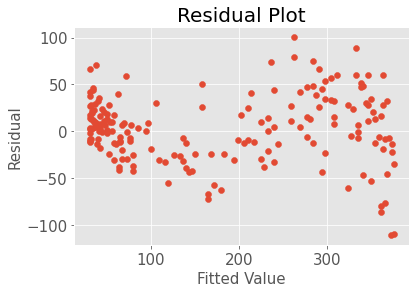

In [ ]:
# residual plot - polynomial regression
residuals_poly1 = y_test - y_pred_poly1
plt.scatter(y_pred_poly1, residuals_poly1)
plt.xlabel('Fitted Value', size = 15)
plt.ylabel('Residual', size = 15)
plt.title('Residual Plot', size = 20)
plt.show() # pattern

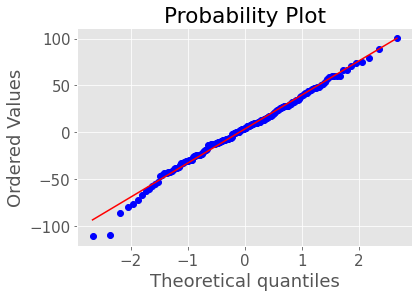

In [ ]:
# Q-Q plot - polynomial regression
# https://cloud.tencent.com/developer/article/1536551
from scipy.stats import probplot
probplot(residuals_poly1, plot = plt)
plt.show() # normal

## 3) Polynomial regression model (degree = 2) <a class="anchor" id="section3_3"></a >

rmse: 32.38366872058626


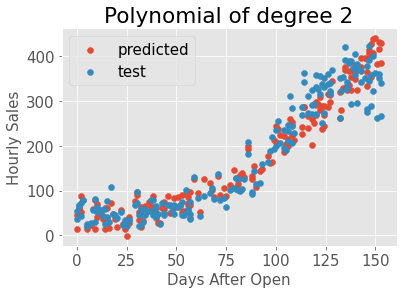

In [ ]:
# variable selection
predictors = ['days_after_open', 'days_after_open^2', 'raining_yes', 'hours_after_open_0',
       'hours_after_open_1', 'hours_after_open_2', 'hours_after_open_3',
       'hours_after_open_4', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
       'day_of_week_4', 'day_of_week_5', 'day_of_week_6']

X = df_transaction2[predictors].to_numpy().reshape(-1,len(predictors))
y = df_transaction2['hourly_sales'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

linear_reg = LinearRegression(fit_intercept = True)
linear_reg.fit(X_train, y_train)
y_pred_poly2 = linear_reg.predict(X_test.reshape(-1,len(predictors)))

# test MSE
print('rmse:', MSE(y_test, y_pred_poly2)**0.5)

plt.scatter(X_test[:,0], y_pred_poly2, label = 'predicted')
plt.scatter(X_test[:,0], y_test, label = 'test')
plt.legend()
plt.xlabel('Days After Open', size = 15)
plt.ylabel('Hourly Sales', size = 15)
plt.title('Polynomial of degree 2')
plt.show()

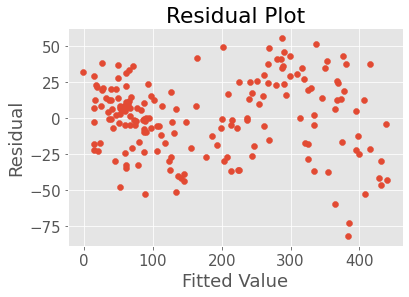

In [ ]:
# residual plot - polynomial regression
residuals_poly2 = y_test - y_pred_poly
plt.scatter(y_pred_poly2, residuals_poly2)
plt.xlabel('Fitted Value')
plt.ylabel('Residual')
plt.title('Residual Plot')
plt.show()

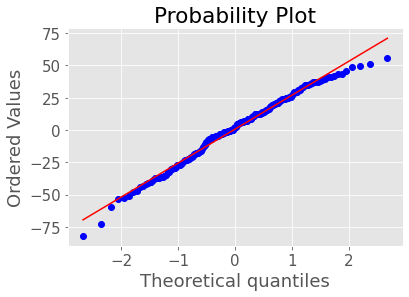

In [ ]:
# Q-Q plot - polynomial regression

probplot(residuals_poly2, plot = plt)
plt.show()